In [1]:
# Imports
import numpy as np
import pandas as pd
import yaml
from brand import initializeRedisFromYAML
from sklearn import metrics
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers

from utils import get_lagged_features, load_stream

In [2]:
# Options
BATCH_SIZE = 2048
LR = 1e-1
NORMALIZE = True  # whether to normalize the data

In [3]:
# Load Data
# connect to Redis
r = initializeRedisFromYAML('replayTest.yaml')

# load stream information
with open('stream_spec.yaml', 'r') as f:
    stream_spec = yaml.safe_load(f)

# load taskInput stream
task_input = load_stream(r, 'taskInput', stream_spec=stream_spec)
task_input = task_input.set_index('timestamps')

# load thresholdCrossings stream
threshold_crossings = load_stream(r,
                                  'thresholdCrossings',
                                  stream_spec=stream_spec)
# separate channels into their own columns
tc_timestamps = threshold_crossings['timestamps'].values
crossings = np.stack(threshold_crossings['crossings'])
n_chans = crossings.shape[1]

# correct the offset between thresholdCrossings and taskInput
offsets = list(range(-15, 16))
idx = np.argmax([
    np.intersect1d(task_input.index, tc_timestamps + i).shape[0]
    for i in offsets
])
offset = offsets[idx]

channel_labels = [f'ch{i :03d}' for i in range(n_chans)]
tc_df = pd.DataFrame(crossings,
                     index=tc_timestamps + offset,
                     columns=channel_labels)

# combine the taskInput and thresholdCrossing data
joined_df = task_input.join(tc_df, how='inner')
# convert index from samples to milliseconds
joined_df.index = pd.to_timedelta(joined_df.index / 30, unit='ms')

# split the behavioral data into columns
samples = np.stack(joined_df['samples'])
joined_df['touch'] = samples[:, 0]
joined_df['x'] = samples[:, 1]
joined_df['y'] = samples[:, 2]

connecting to Redis using: replayTest.yaml
Redis IP: 127.0.0.1, Redis port: 6379
Initialized Redis


In [4]:
# Pre-Processing
# resample the data
bin_size_ms = 5  # ms
binned_data = joined_df.resample(f'{bin_size_ms :d}ms').mean().dropna(axis=0)

# define the input X and output y
X = binned_data[channel_labels].values
y = binned_data[['x', 'y']].values

# get features
X = get_lagged_features(X, n_history=50)

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

if NORMALIZE:
    # scale the output
    output_scaler = StandardScaler()
    y_train = output_scaler.fit_transform(y_train)
    y_test = output_scaler.transform(y_test)

In [5]:
# Train a Linear Model
linear_model = Ridge(alpha=1.0)
linear_model.fit(X_train, y_train)

print(f'Train R^2: {linear_model.score(X_train, y_train)}')
print(f'Test R^2: {linear_model.score(X_test, y_test)}')

output = linear_model.predict(X)
if NORMALIZE:
    output = output_scaler.inverse_transform(output)
binned_data['x_pred_lm'] = output[:, 0]
binned_data['y_pred_lm'] = output[:, 1]

Train R^2: 0.7895980114926895
Test R^2: 0.7724685885486283


In [6]:
# Train a Neural Network
n_features = X_train.shape[1]
n_targets = y_train.shape[1]

# define the model
nn_model = keras.Sequential()
nn_model.add(layers.Input(shape=(n_features, )))
nn_model.add(
    layers.Dense(n_targets,
                 activation=None,
                 kernel_regularizer=keras.regularizers.l2(1e-4)))

# initialize the model graph
nn_model(np.random.rand(BATCH_SIZE, n_features))  # init

# compile the model
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=LR, decay_steps=10000, decay_rate=0.90)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
nn_model.compile(optimizer=optimizer, loss=keras.losses.MeanSquaredError())

callbacks = [
    # Stop training when `val_loss` is no longer improving
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=1e-4,  # minimum improvement
        patience=5,  # epochs
        verbose=1,
    )
]

nn_model.fit(X_train,
             y_train,
             validation_data=(X_test, y_test),
             batch_size=BATCH_SIZE,
             epochs=100,
             callbacks=callbacks)

output = nn_model(X).numpy()
if NORMALIZE:
    output = output_scaler.inverse_transform(output)
binned_data['x_pred_nn'] = output[:, 0]
binned_data['y_pred_nn'] = output[:, 1]

Epoch 1/100
53/53 [==============================] - 2s 24ms/step - loss: 5.5902 - val_loss: 0.4526
Epoch 2/100
53/53 [==============================] - 1s 12ms/step - loss: 0.2952 - val_loss: 0.2590
Epoch 3/100
53/53 [==============================] - 1s 11ms/step - loss: 0.2382 - val_loss: 0.2426
Epoch 4/100
53/53 [==============================] - 1s 11ms/step - loss: 0.2273 - val_loss: 0.2384
Epoch 5/100
53/53 [==============================] - 1s 11ms/step - loss: 0.2264 - val_loss: 0.2414
Epoch 6/100
53/53 [==============================] - 1s 12ms/step - loss: 0.2263 - val_loss: 0.2409
Epoch 7/100
53/53 [==============================] - 1s 11ms/step - loss: 0.2281 - val_loss: 0.2402
Epoch 8/100
53/53 [==============================] - 1s 12ms/step - loss: 0.2286 - val_loss: 0.2410
Epoch 9/100
53/53 [==============================] - 1s 12ms/step - loss: 0.2289 - val_loss: 0.2377
Epoch 10/100
53/53 [==============================] - 1s 11ms/step - loss: 0.2311 - val_loss: 0.2414

In [7]:
metrics.r2_score(binned_data[['x']], binned_data[['x_pred_nn']])

0.4711364957770364

In [8]:
W_nn, b_nn = nn_model.get_weights()

In [9]:
W_lm = linear_model.coef_.T
b_lm = linear_model.intercept_

In [10]:
# Compare the weights
np.abs(W_lm).sum(axis=0), np.abs(W_nn).sum(axis=0)

(array([261.66132709,   0.        ]),
 array([254.63472  ,   1.9410652], dtype=float32))

In [11]:
# Compare biases
b_lm, b_nn

(array([1.20347333, 0.        ]),
 array([0.5821776 , 0.02821562], dtype=float32))

In [12]:
# Compare the norm of the weights
np.linalg.norm(W_lm), np.linalg.norm(W_nn)

(4.917285383319742, 4.801489)

In [13]:
# Split the data into trials
# state: [start_trial, movement, reward, failure, between_trials]
state = load_stream(r, 'state', stream_spec=stream_spec)
state.sort_values('sync', inplace=True)
# Assign trial numbers
state['trial_id'] = None  # make a new column

# number the 'start_trial' tokens
mask = state['state'] == 'start_trial'
state.loc[mask, 'trial_id'] = np.arange(len(state[mask]))

# assign the 'start_trial' number to tokens that come after it
current_trial = None
trial_ids = np.empty_like(state['trial_id'])
for i in range(state.shape[0]):
    if state['trial_id'].iloc[i] is not None:
        current_trial = state['trial_id'].iloc[i]
    trial_ids[i] = current_trial
state['trial_id'] = trial_ids

trials = state.pivot(index='trial_id', columns='state', values='sync')
trials.sort_index(axis=1, inplace=True)  # sort columns after pivoting
# drop failed trials and the between-trial period
trials.drop(['between_trials', 'failure'], axis=1, inplace=True)
trials.dropna(axis=0, inplace=True)  # drop incomplete trials
trials = trials / 30  # convert to milliseconds
for field in trials.columns:
    trials[field] = pd.to_timedelta(trials[field], unit='ms')

trial_dfs = []
align_field = 'movement'
start_offset, end_offset = pd.to_timedelta((-500, 1000), unit='ms')
bin_width = pd.to_timedelta(bin_size_ms, unit='ms')
for tid in trials.index.values:
    center = trials[align_field].loc[tid]
    a = center + start_offset
    b = center + end_offset
    trial_df = binned_data.loc[a:b].copy()
    trial_df['trial_id'] = tid
    trial_df['align_time'] = trial_df.index.ceil(bin_width) - center.ceil(
        bin_width)
    trial_dfs.append(trial_df)

# Combine all trials into one DataFrame
trial_data = pd.concat(trial_dfs, ignore_index=True)
aligned_trials = trial_data.pivot_table(index='align_time', columns='trial_id')

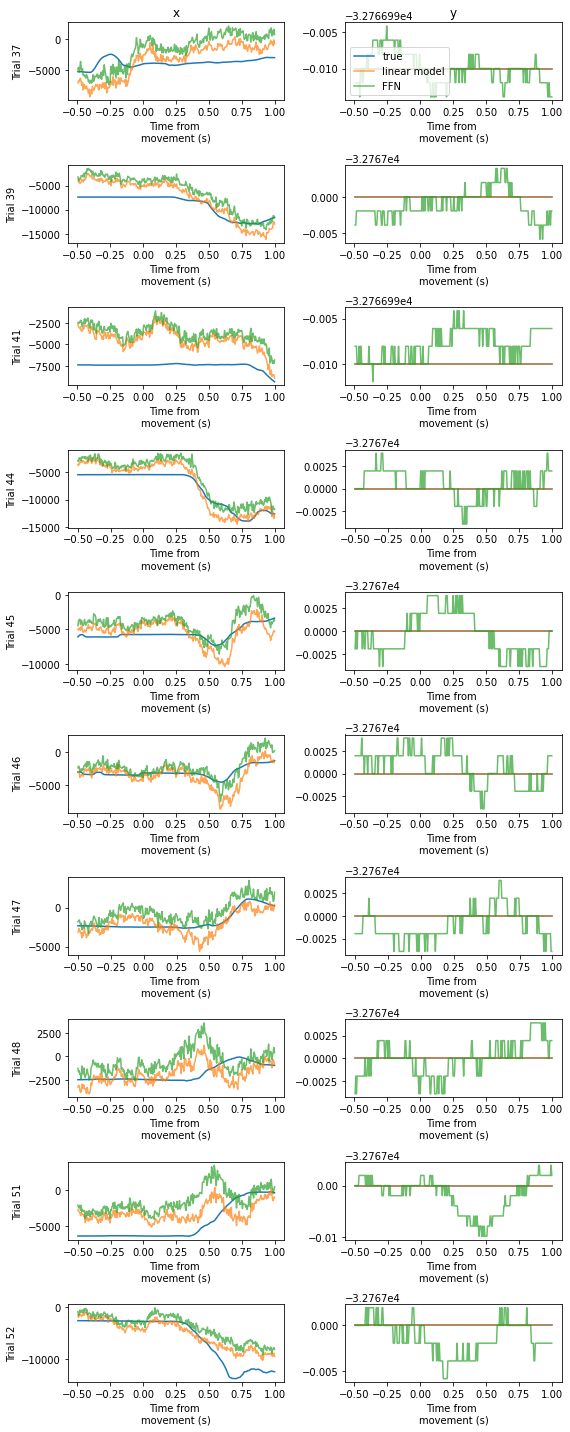

In [14]:
# plot predictions
import matplotlib.pyplot as plt

trial_ids = trial_data['trial_id'].unique()[:10]

fig, axes = plt.subplots(ncols=2,
                         nrows=len(trial_ids),
                         figsize=(8, 2 * len(trial_ids)))

for i, trial_id in enumerate(trial_ids):
    t = aligned_trials.index.total_seconds()
    axes[i, 0].plot(t, aligned_trials['x'][trial_id], label='true')
    axes[i, 0].plot(t,
                    aligned_trials['x_pred_lm'][trial_id],
                    label='linear model',
                    alpha=0.7)
    axes[i, 0].plot(t,
                    aligned_trials['x_pred_nn'][trial_id],
                    label='FFN',
                    alpha=0.7)
    axes[i, 0].set_xlabel(f'Time from \n{align_field} (s)')
    axes[i, 0].set_ylabel(f'Trial {trial_id}')
    axes[i, 1].plot(t, aligned_trials['y'][trial_id], label='true')
    axes[i, 1].plot(t,
                    aligned_trials['y_pred_lm'][trial_id],
                    label='linear model',
                    alpha=0.7)
    axes[i, 1].plot(t,
                    aligned_trials['y_pred_nn'][trial_id],
                    label='FFN',
                    alpha=0.7)
    axes[i, 1].set_xlabel(f'Time from \n{align_field} (s)')
axes[0, 0].set_title('x')
axes[0, 1].set_title('y')
axes[0, -1].legend()

plt.tight_layout()
plt.savefig('force_predictions.pdf')